# Distilling Diverse Counterfactual Explanations

![](images/distill-dice/introduction.jpeg "DiCE")

# Introduction

Continuing my series of post, this time I'll provide an introdutory elucidation of `Counterfactual Explanations`, an interest concept that goes in the same direction of model explanation, but it is different than feature attribution methods like [@LIMEPaper] and [@SHAPPaper].

Simply speaking, according to authors from [@dice], suppose that someone who tried to get a loan but got turned down by the bank's computer system. Normally, the bank might tell them why, like "you have a bad credit history". But this doesn't give the person a clue about what they should do differently next time to get approved. Also, what the system flagged as most important might not even be something they can change, e.g. their `gender` or `race`. So, it's super crucial not only to know why you got rejected, but **also to see what changes could lead to a different result**. This way, people can figure out what actions they could've taken to swing the decision in their favor.

This leads us to the definition of Counterfactual Explanations [@CounterFactualWatcher]. Using the loan example, these would show how the same person could have changed a few things to get approved for the loan. For instance, they might say "if you earned $10,000 more, you'd have gotten the loan." Basically, these are "what-if" scenarios based on the model's results. A big plus of these counterfactual explanations is that they're always true to the original model since they're just a different take on the system's results. Plus, they can be easy for people to understand.



## The caveat

Coming up with "what-if" scenarios that someone can actually do is tough. Let's go back to the loan example. A counterfactual explanation might suggest "lower your rent", but it doesn't give other options or consider how hard different changes might be to pull off. That's why we need a variety of counterfactual examples to help people wrap their heads around these complex machine learning models. Ideally, these examples should offer a range of suggestions and think about how doable those changes are. 

:::{.callout-important}

Rules should make sense with real-world rules, like, you can't just downgrade your degree or change your race.

:::

### But what is wrong with Feature Importance methods?

Models like those mentioned in the [@LIMEPaper] and [@SHAPpaper] papers are seen as "Feature Importance" methods. They explain things by ranking the most relevant features. But here's the thing, these explanations aren't totally honest about what's going on with the machine learning models. As there is always this balancing act between being true to the model and making it understandable to humans when you're explaining a complex model, an explanation methods that use simpler stand-in models are always approximatios the real model to some extent. Therefore, one big issue with this is that because the explanations come from these simpler models, there's no guarantee that they're actually representing the original model accurately.

## Approaching the solution

Extending the work from [@CounterFactualWatcher], [@dice] authors set up an optimization problem that looks at both the diversity of the "what-if" scenarios and how close they are to the original data, coming up with a method that generates a bunch of "what-if" scenarios. Also, they provide a set of interesting metrics for evaluating counterfactual explanations, which I believe is worthwhile to explore :)

## Going Formal

So, what we're working with here is a trained machine learning model, $f$, and a specific case, $x$. Our aim is to generate a group of $k$ counterfactuals, {$c_1, c_2, \cdots{. . .}, c_k$}, that would lead to a different outcome than $x$. Both $x$ and all the CF examples (${c_1, c_2, \cdots{. . .} , c_k}$) are $d\text{-dimensional}$. Throughout this paper, we're assuming that the machine learning model is differentiable and static (it doesn't change over time), and that the output is **binary**.

Our goal is to generate an actionable counterfactual set, that is, the user should be able to find CF examples that they can act upon. To do so, we need individual CF examples to be feasible with respect to the original input, but also need diversity among the generated counterfactuals to provide different ways of changing the outcome class.

### Counterfactuals Generation Engine


Let's say you have an input feature $x$ and an output from an ML model $f$. A counterfactual explanation is a tweak to the input that causes a different output $y$ from the same model. Specifically, Wachter and his team came up with this idea:

$$
\begin{aligned}
x_{cf} = \arg \min_{x_{cf}} \quad & yloss(f(x_{cf}), y) + |x - x_{cf}| \\
\text{s.t.} \quad & f(x_{cf}) = y', y' \neq y
\end{aligned}
$$


In plain terms, the first component (_yloss_) drives the counterfactual $x_{cf}$ towards a prediction that's different from the original data point. Meanwhile, the second component ensures the counterfactual stays relatively close to the original data point.

For simplicity, for now on, lets assume that $x_{cf}=c$

### New set of metrics

As mentioned, authors from [@dice] implements a new set of metrics and definitions that I am going to explain further. In other words, while having a bunch of different counterfactuals might boost the odds of finding at least one a person can act on, the examples could end up tweaking a ton of features. Or, they might go for maximum diversity by suggesting big changes from the original data. This issue could get even trickier when you're dealing with lots of features. So, we need a mix of **diversity** and **feasibility**, which I'll lay out next.

#### Diversity via Determinantal Point Processes

When it comes to diversity, we're borrowing from something called determinantal point processes [@DPP]. These have been used to tackle subset selection problems with diversity constraints. We measure diversity with this determinant of a kernel matrix that is based on the counterfactuals:

$$
\begin{aligned}
\text{dpp\_diversity}(x) = \det(K(x))
\end{aligned}
$$

Here, $K_{i,j} = \frac{1}{1+dist(x_i,c_j)}$, where $dist(c_i,c_j)$ is a way to measure the distance between two counterfactual examples. In practice, to dodge issues with undefined determinants, we add small random changes to the diagonal elements when we calculate the determinant.

If we want to have quick and dirty implementation about that, here it is [^1]:

In [4]:
#| code-fold: true

import numpy as np
import scipy.spatial.distance as distance

def create_k_matrix(counterfactuals, distance_func, eps=1e-6):
    """
    Creates a kernel matrix K based on counterfactuals and a given distance function.
    
    Parameters:
    counterfactuals (numpy.ndarray): A 2D array containing counterfactuals.
    distance_func (function): A function to measure distance between two counterfactual examples.
    eps (float): A small value added to the diagonal of the matrix to avoid determinant issues.
    
    Returns:
    numpy.ndarray: The kernel matrix K.
    """
    
    num_counterfactuals = len(counterfactuals)
    K = np.zeros((num_counterfactuals, num_counterfactuals))
    
    for i in range(num_counterfactuals):
        for j in range(i+1, num_counterfactuals):
            dist = distance_func(counterfactuals[i], counterfactuals[j])
            K[i, j] = K[j, i] = 1 / (1 + dist)
    
    # Add small perturbations to the diagonal elements
    np.fill_diagonal(K, np.diag(K) + eps)
    
    return K

[^1]: As always, ChatGPT is being a true "friend" when creating these boilerplate code :)

#### Proximity

So, the counterfactual examples that are closest to the original data are usually the most helpful for users. We calculate proximity as the (negative) vector distance between the original data and the features of the counterfactual example. This can be figured out using a distance metric like the $\ell_{1}\text{-distance}$ (and you can weight this by feature if you want). The proximity of a set of counterfactual examples is just the average proximity across the set.

$$
\begin{aligned}
-\frac{1}{k}\sum^{k}_{i=1}\text{dist}(c_i,x)
\end{aligned}
$$

As expected, here is an attempt of implementation

In [5]:
#| code-fold: true

from scipy.spatial import distance

def compute_proximity(x, c, dist_function='euclidean'):
    # Calculate the distance between x and each counterfactual in c
    distances = np.array([distance.cdist([x], [c_i], dist_function) for c_i in c])

    # Calculate the average proximity across the set
    proximity = -np.mean(distances)

    return proximity

#### Sparsity

Closely linked to proximity is the concept of **sparsity**: it's about determining the **number of features** someone needs to alter to reach the counterfactual class. It's intuitive that a counterfactual example will be more feasible if it modifies fewer features. As this constraint is non-convex (it doesn't have a simple, consistent shape), we don't include it in the loss function. Instead, we manage it by modifying the counterfactuals we generate.

#### User Constraints

A counterfactual example might seem feasible if you're just looking at the features, but real-world restrictions could make it a no-go. So, it's a good idea to let users set some constraints on how features can be changed. These can be defined in two ways. First, as box constraints that set feasible ranges for each feature—this is where we need to look for counterfactual examples. Like, "income can't go above 200,000". Or, a user could just list the variables they're okay with changing.

### Optimizing everything

The authors then propose a combined loss function, $C(x)$, that considers all generated counterfactuals:

\begin{aligned}
\arg \min_{c_1, \cdots, c_k} \quad & \frac{1}{k} \sum^{k}_{i=1} yloss(f(c_i), y) + \frac{\lambda_{1}}{k} \sum^{k}_{i=1} dist(c_i, x) - \lambda_{2} \text{dpp\_diversity}(c_1, \cdots, c_k)
\end{aligned}


In this equation, $c_i$ represents a counterfactual example (CF), $k$ is the total number of CFs we want to make, $f(\cdot)$ is the ML model, $yloss(\cdot)$ is a metric that shrinks the distance between $f(\cdot)$'s prediction for $c_i$ and the preferred outcome $y$, $x$ is the initial input, and $\text(dpp_diversity)(\cdot)$ is the diversity metric. $\lambda1$ and $\lambda_2$ are hyperparameters.

In [6]:
# MISSING CODE

## The Dataset

For learning purposes, let's use a simple dataset generator from scikit-learn which I trained a `LGBMClassifier`

In [1]:
#| code-fold: true

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# Generate a 2D dataset with two classes
np.random.seed(42)
X, y = make_blobs(n_samples=200, centers=2, random_state=42, cluster_std=2.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the LightGBM classifier
clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

LGBMClassifier(random_state=42)

Also, I want to explain a single instance from `test` set. Let's take the first element :)

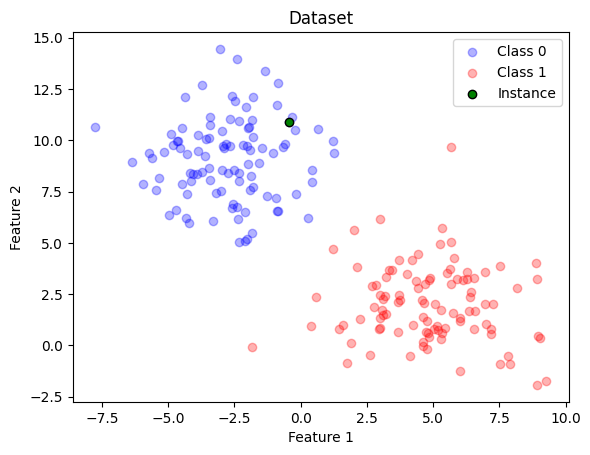

In [2]:
instance_to_explain = np.where(X==X_test[0])[0][0]

assert (X[instance_to_explain]==X_test[0]).all()

def plot_dataset_with_instance(X, y, highlight_row=None, title="Dataset"):
    # Assuming you have two classes 0 and 1
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    # Create a scatter plot for each class
    plt.scatter(class_0[:, 0], class_0[:, 1], c='blue', label='Class 0', alpha=0.3)
    plt.scatter(class_1[:, 0], class_1[:, 1], c='red', label='Class 1', alpha=0.3)
    
    if highlight_row is not None:
        plt.scatter(X[highlight_row, 0], X[highlight_row, 1], c='green', label='Instance', alpha=1, marker='o', edgecolors='k')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    
    # Add a legend to the plot
    plt.legend()
    
    plt.show()

# Pass in the index of the row you want to highlight
plot_dataset_with_instance(X, y, highlight_row=instance_to_explain)

Therefore, we want to find the _set of candidates_ that makes the **green** instance becomes **red**

## Evaluating Counterfactuals